In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import random
import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [32]:
# Step 1: Load annotations from the CSV file and sort it to match the image folder
csv_file = "/kaggle/input/plate-car-detection/Car_detection/train_labels.csv"  # Update the path to the CSV file
df = pd.read_csv(csv_file)
# annotations = annotations.sort_values(by='filename')



In [33]:

df = df.sort_values(by=["filename"])
df.head(5)


,filename,width,height,class,xmin,ymin,xmax,ymax
18,Data-Images/Cars/0.jpg,119,47,license_plate,581,273,700,320
148,Data-Images/Cars/1.jpg,209,68,license_plate,79,381,288,449
70,Data-Images/Cars/10.jpg,222,81,license_plate,199,138,421,219
201,Data-Images/Cars/100.jpg,199,109,license_plate,28,52,227,161
142,Data-Images/Cars/101.jpg,206,98,license_plate,20,55,226,153


In [34]:

df["image_name"] = df["filename"].apply(lambda link: os.path.basename(link))
df = df.sort_values(by=["filename"])
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,image_name
18,Data-Images/Cars/0.jpg,119,47,license_plate,581,273,700,320,0.jpg
148,Data-Images/Cars/1.jpg,209,68,license_plate,79,381,288,449,1.jpg
70,Data-Images/Cars/10.jpg,222,81,license_plate,199,138,421,219,10.jpg
201,Data-Images/Cars/100.jpg,199,109,license_plate,28,52,227,161,100.jpg
142,Data-Images/Cars/101.jpg,206,98,license_plate,20,55,226,153,101.jpg


In [37]:
image_folder = "/kaggle/input/plate-car-detection/Car_detection/Cars/Cars"
# Read the image dimensions and normalize the bounding box values
for index, row in df.iterrows():
    image_path = os.path.join(image_folder, row["image_name"])
    image = cv2.imread(image_path)
    image_height, image_width, _ = image.shape

    df.at[index, "xmin"] = row["xmin"] / image_width
    df.at[index, "ymin"] = row["ymin"] / image_height
    df.at[index, "xmax"] = row["xmax"] / image_width
    df.at[index, "ymax"] = row["ymax"] / image_height


In [38]:

df


,filename,width,height,class,xmin,ymin,xmax,ymax,image_name
18,Data-Images/Cars/0.jpg,119,47,license_plate,0.720844,0.585837,0.868486,0.686695,0.jpg
148,Data-Images/Cars/1.jpg,209,68,license_plate,0.159919,0.848552,0.582996,1.000000,1.jpg
70,Data-Images/Cars/10.jpg,222,81,license_plate,0.309969,0.345000,0.655763,0.547500,10.jpg
201,Data-Images/Cars/100.jpg,199,109,license_plate,0.112903,0.293785,0.915323,0.909605,100.jpg
142,Data-Images/Cars/101.jpg,206,98,license_plate,0.080645,0.310734,0.911290,0.864407,101.jpg
...,...,...,...,...,...,...,...,...,...
47,Data-Images/Cars/95.jpg,369,115,license_plate,0.313869,0.436913,0.698644,0.556830,95.jpg
15,Data-Images/Cars/96.jpg,281,75,license_plate,0.350000,0.548571,0.662222,0.762857,96.jpg
159,Data-Images/Cars/97.jpg,98,53,license_plate,0.348571,0.591837,0.628571,0.862245,97.jpg
122,Data-Images/Cars/98.jpg,188,84,license_plate,0.100806,0.355932,0.858871,0.830508,98.jpg


In [31]:
# images_directory = "/kaggle/input/plate-car-detection/Car_detection/Cars"  # Update the path to the image folder
# images, bounding_boxes = load_images_and_annotations(annotations, images_directory)




/tmp/ipykernel_28/1028290089.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(images), np.array(bounding_boxes)


In [39]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_dataframe(
    df,
    directory="/kaggle/input/plate-car-detection/Car_detection/Cars",
    x_col="image_name",
    y_col=["xmin", "ymin", "xmax", "ymax"],
    target_size=(299, 299),
    batch_size=16,
    class_mode='raw',
    subset="training")

validation_generator = datagen.flow_from_dataframe(
    df,
    directory="/kaggle/input/plate-car-detection/Car_detection/Cars",
    x_col="image_name",
    y_col=["xmin", "ymin", "xmax", "ymax"],
    target_size=(299, 299),
    batch_size=16,
    class_mode='raw',
    subset="validation")

Found 190 validated image filenames.
Found 47 validated image filenames.


In [40]:

inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(299,299,3)))
# ---------------------
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dropout(0.25)(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dropout(0.25)(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)

model = Model(inputs=inception_resnet.input,outputs=headmodel)

In [41]:
import tensorflow_addons as tfa

# Step 5: Compile the model with the SSD optimizer
initial_learning_rate = 1e-3
optimizer = tfa.optimizers.SGDW(weight_decay=0.0005, learning_rate=initial_learning_rate, momentum=0.9)
model.compile(loss='mse', optimizer=optimizer)



In [42]:
from tensorflow.keras.callbacks import TensorBoard
tfb = TensorBoard('object_detection')
history = model.fit(train_generator,batch_size=16,epochs=50,
                    validation_data=validation_generator,callbacks=[tfb])

Epoch 1/50
12/12 [==============================] - 35s 973ms/step - loss: 0.0734 - val_loss: 0.0378
Epoch 2/50
12/12 [==============================] - 7s 590ms/step - loss: 0.0421 - val_loss: 0.0308
Epoch 3/50
12/12 [==============================] - 7s 601ms/step - loss: 0.0277 - val_loss: 0.0297
Epoch 4/50
12/12 [==============================] - 7s 609ms/step - loss: 0.0262 - val_loss: 0.0254
Epoch 5/50
12/12 [==============================] - 7s 604ms/step - loss: 0.0210 - val_loss: 0.0213
Epoch 6/50
12/12 [==============================] - 7s 607ms/step - loss: 0.0170 - val_loss: 0.0204
Epoch 7/50
12/12 [==============================] - 7s 611ms/step - loss: 0.0162 - val_loss: 0.0190
Epoch 8/50
12/12 [==============================] - 7s 608ms/step - loss: 0.0147 - val_loss: 0.0192
Epoch 9/50
12/12 [==============================] - 7s 604ms/step - loss: 0.0130 - val_loss: 0.0196
Epoch 10/50
12/12 [==============================] - 7s 603ms/step - loss: 0.0132 - val_loss: 0.018

In [43]:
model.evaluate_generator(validation_generator)

0.014700690284371376

In [44]:
WIDTH= 299
HEIGHT= 299


1/1 [==============================] - 3s 3s/step


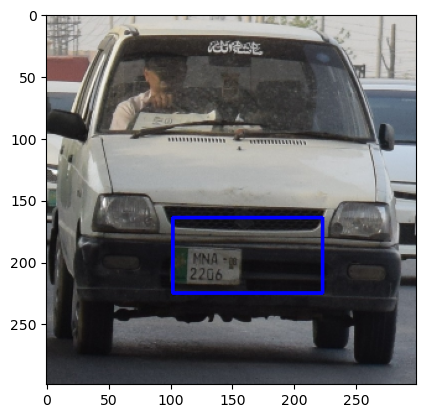

1/1 [==============================] - 0s 43ms/step


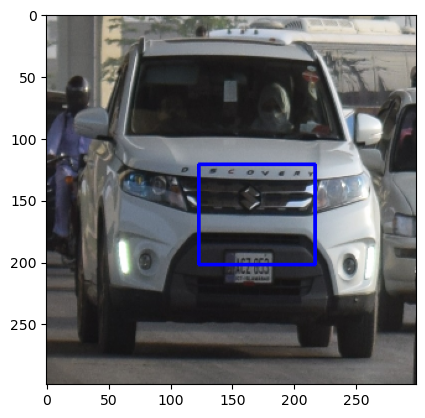

1/1 [==============================] - 0s 43ms/step


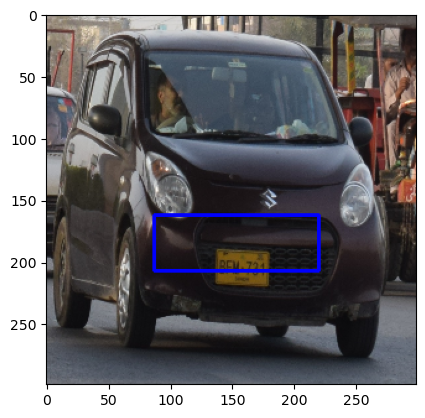

In [45]:
images_folder = "/kaggle/input/testss/car_with_diff"
image_files = os.listdir(images_folder)

for image_file in image_files:
    img_path = os.path.join(images_folder, image_file)
    img = cv2.resize(cv2.imread(img_path) / 255.0, dsize=(WIDTH, HEIGHT))
    y_hat = model.predict(img.reshape(1, WIDTH, HEIGHT, 3)).reshape(-1) * WIDTH

    xt, yt = int(y_hat[0]), int(y_hat[1])
    xb, yb = int(y_hat[2]), int(y_hat[3])

    img = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_BGR2RGB)
    image = cv2.rectangle(img, (xt, yt), (xb, yb), (0, 0, 255), 2)
    plt.imshow(image)
    plt.show()

1/1 [==============================] - 0s 42ms/step


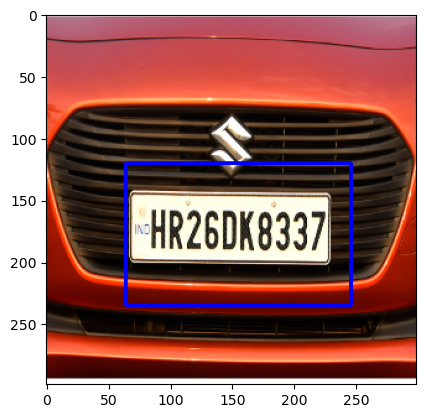

In [46]:
images_folder = "/kaggle/input/testingtest"
image_file = "/kaggle/input/testingtest/testing.png"

img_path = os.path.join(images_folder, image_file)
img = cv2.resize(cv2.imread(img_path) / 255.0, dsize=(WIDTH, HEIGHT))
y_hat = model.predict(img.reshape(1, WIDTH, HEIGHT, 3)).reshape(-1) * WIDTH

xt, yt = int(y_hat[0]), int(y_hat[1])
xb, yb = int(y_hat[2]), int(y_hat[3])
roi = img[yt:yb, xt:xb]

img = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_BGR2RGB)
image = cv2.rectangle(img, (xt, yt), (xb, yb), (0, 0, 255), 2)
plt.imshow(image)

In [48]:
import plotly.express as px
fig = px.imshow(roi)
fig.update_layout(width=350, height=250, margin=dict(l=10, r=10, b=10, t=10), xaxis_title='Figure 15 Cropped image')
fig.show()

In [49]:
#ocr
import pytesseract as pt
roi_uint8 = (roi * 255).astype(np.uint8)
text = pt.image_to_string(roi_uint8)
print(text)

-HR26DK8337



Lets view some predictions and detected objects 